# Fine Tuning HuggingFace 'bert-base-uncased' for Rating prediction of Movie Reviews by different Users

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Wed Apr 17 08:47:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Importing the libraries
# The Goal is to fine tune the bert-base model to predict a 1 to 5 star rating from Movie reviews

from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup, DataCollatorWithPadding

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim

import matplotlib.pyplot as plt
from matplotlib import rc

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict
from textwrap import wrap

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='darkgrid', palette='pastel', font_scale=1.5)
sns.set_palette(sns.color_palette("Paired"))

rcParams['figure.figsize'] = 12,8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def get_gpu_memory_info():
    """Return GPU memory information for each available GPU."""
    gpu_memory_info = []
    for i in range(torch.cuda.device_count()):
        try:
            gpu = torch.cuda.get_device_properties(i)
            gpu_memory_info.append((i, gpu.name, gpu.total_memory / 1024**2))  # Total memory in MB
        except Exception as e:
            print(f"Error accessing GPU {i}: {e}")
    return gpu_memory_info

def get_gpu_memory_usage():
    """Return GPU memory usage in MB for each available GPU."""
    gpu_memory_usage = []
    for i in range(torch.cuda.device_count()):
        try:
            gpu = torch.cuda.get_device_properties(i)
            gpu_memory = torch.cuda.memory_allocated(i) / 1024**2  # Memory allocated in MB
            gpu_memory_usage.append((i, gpu.name, gpu_memory))
        except Exception as e:
            print(f"Error accessing GPU {i}: {e}")
    return gpu_memory_usage

def check_gpu_info():
    if torch.cuda.is_available():
        # Get GPU memory information for each GPU
        gpu_memory_info = get_gpu_memory_info()

        if gpu_memory_info:
            # Sort GPUs by total memory available
            sorted_gpu_memory = sorted(gpu_memory_info, key=lambda x: x[2], reverse=True)

            # Print GPU information
            print("GPU memory information:")
            for gpu_info in sorted_gpu_memory:
                print(f"GPU {gpu_info[0]} ({gpu_info[1]}): {gpu_info[2]:.2f} MB total memory")
        else:
            print("No GPUs found or unable to access GPU information.")

        # Get GPU memory usage for each GPU
        gpu_memory_usage = get_gpu_memory_usage()

        if gpu_memory_usage:
            # Sort GPUs by memory usage
            sorted_gpu_memory = sorted(gpu_memory_usage, key=lambda x: x[1], reverse=True)

            # Print the GPU with the highest memory usage
            print("GPU with the highest memory usage:")
            print(f"GPU {sorted_gpu_memory[0][0]} ({sorted_gpu_memory[0][1]}): {sorted_gpu_memory[0][2]:.2f} MB")
        else:
            print("No GPUs found or unable to access GPU information.")
    else:
        print("CUDA is not available. Make sure CUDA is properly installed and configured.")

In [4]:
check_gpu_info()

GPU memory information:
GPU 0 (Tesla T4): 15102.06 MB total memory
GPU with the highest memory usage:
GPU 0 (Tesla T4): 0.00 MB


## Parsing and Mapping the Dataset

In [5]:
parquet_file_path = '/content/drive/MyDrive/IMDB_User_Movie_Rating_Dataset_By_Web_Scrapping/Final_IMDB_dataset_users_movie_review_rating.parquet'

df = pd.read_parquet(parquet_file_path)
df

,UserID,MovieID,Review,Rating
0,ur0000001,tt1144884,A very mediocre addition to the Final Destinat...,4
1,ur0000002,tt0119237,Memo to Mr. Korine: a movie should have someth...,2
2,ur0000002,tt0120741,All the good jokes were in the trailer. This ...,5
3,ur0000002,tt0134619,"As a paranoia thriller, this mostly works as f...",4
4,ur0000002,tt0120746,Cracking yarn. And decent swordplay as well. ...,7
...,...,...,...,...
17003,ur0101084,tt0115571,"The Arrival has talented actors, reasonable sp...",5
17004,ur0101084,tt6794990,The story begins with finding a missing female...,4
17005,ur0101106,tt0191653,I'll usually just flip right by a movie when I...,6
17006,ur0101106,tt0184456,The Apollo Movie Guide was right. Since I had...,4


In [6]:
unique_users = len(df['UserID'].unique())
unique_movies = len(df['MovieID'].unique())
total_reviews = df.shape[0]
rating_values = sorted(df.Rating.unique())

print('Information about our Imdb Web Scraped Dataset:')
print(f'- Number of unique users: {unique_users}')
print(f'- Number of unique movies: {unique_movies}')
print(f'- Total number of reviews: {total_reviews}')
print(f'- Unique rating values: {rating_values}')

Information about our Imdb Web Scraped Dataset:
- Number of unique users: 3366
- Number of unique movies: 9335
- Total number of reviews: 17008
- Unique rating values: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [7]:
# Our Imdb Dataset contains rating scale from 1 to 10

# Function to scale down ratings from a 1-10 scale to a 1-5 scale to prepare data for training a model to predict 5-star ratings from reviews
def Scale_down_rating(rating):
    if rating <= 2:
        return 1

    elif rating <= 4:
        return 2

    elif rating <= 6:
        return 3

    elif rating <= 8:
        return 4

    return 5

df['Rating'] = df.Rating.apply(Scale_down_rating)
print('Now Unique Rating values : ')
sorted(df.Rating.unique())

Now Unique Rating values : 


[1, 2, 3, 4, 5]

In [8]:
# Movie Ratings are from 1 to 5 , It can be considered as classes
# Making the Movie Rating to a 0-based index
# Convert 1-5 scale to 0-4 scale

def map_rating(rating):

    if rating == 1:
      return 0

    elif rating == 2:
      return 1

    elif rating == 3:
      return 2

    elif rating == 4:
      return 3

    return 4

df['Rating'] = df.Rating.apply(map_rating)

print('Converted Rating into 0-Indexed Based Rating')
sorted(df.Rating.unique())

Converted Rating into 0-Indexed Based Rating


[0, 1, 2, 3, 4]

<ipython-input-9-91883941a3b2>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rating', data=df,palette=custom_palette)


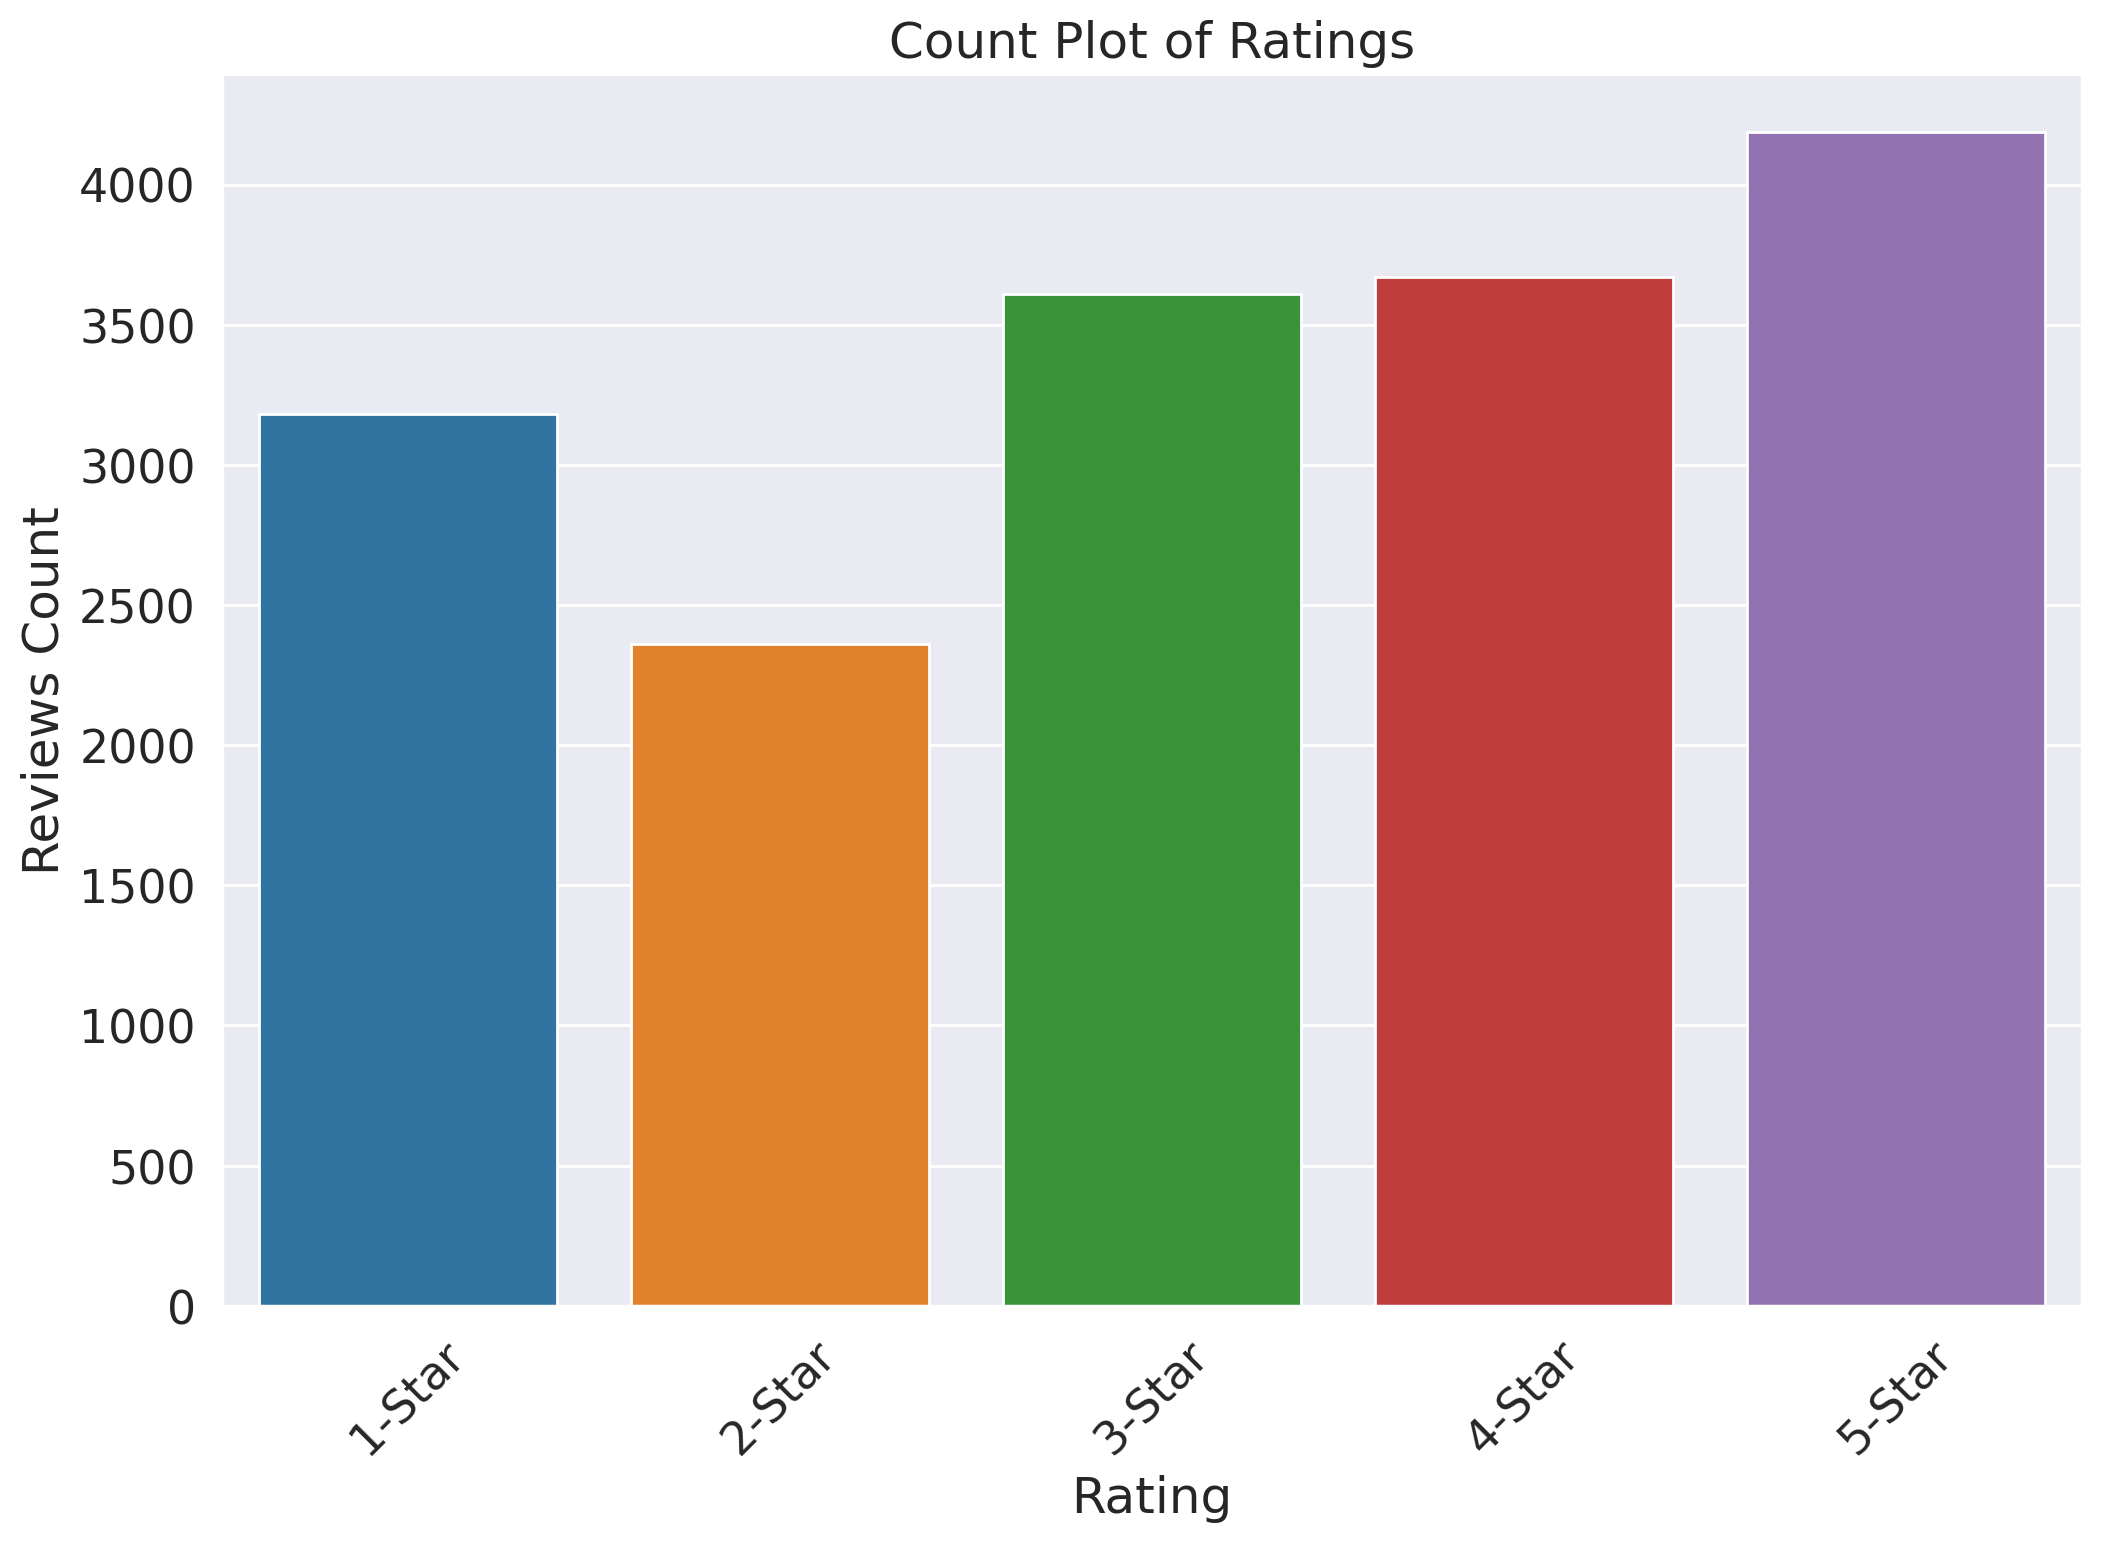

In [9]:
class_names = ['1-Star', '2-Star', '3-Star', '4-Star', '5-Star']
custom_palette = sns.color_palette("tab10")[:len(class_names)]

sns.countplot(x='Rating', data=df,palette=custom_palette)
plt.title('Count Plot of Ratings')
plt.xlabel('Rating')
plt.ylabel('Reviews Count')
plt.xticks(ticks=range(5), labels=class_names, rotation=45)  # Customize x-axis labels
plt.show()

In [10]:
check_gpu_info()

GPU memory information:
GPU 0 (Tesla T4): 15102.06 MB total memory
GPU with the highest memory usage:
GPU 0 (Tesla T4): 0.00 MB


### Review column is be the features and Rating column is the target

In [11]:
reviews = df.Review.to_list()
targets = df.Rating.to_list()

## Defining the Transformer and Tokenizor

In [12]:
pre_trained_model_ckpt = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(pre_trained_model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Tokenization and encoding on a Sample Text

In [14]:
sample_txt = 'Visually stunning captivating performances thrilling ride start to finish'

tokens = tokenizer.tokenize(sample_txt)

token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Visually stunning captivating performances thrilling ride start to finish
   Tokens: ['visually', 'stunning', 'capt', '##ivating', 'performances', 'thrilling', 'ride', 'start', 'to', 'finish']
Token IDs: [17453, 14726, 14408, 17441, 4616, 26162, 4536, 2707, 2000, 3926]


In [15]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length = 32,
    truncation=True,
    padding=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]
    return_token_type_ids=False, # Token type IDs are used in models like BERT that support token types (e.g., sentence pairs for tasks like question answering).
    return_attention_mask=True, # Attention masks indicate which tokens are actual words and which ones are padding tokens
    return_tensors='pt' # Return pytorch tensors
)
# It provides Encoded input sequence and attention mask

# tensors - an Multi-dimension array similar to a numpy array.
# However, tensors are specifically designed to efficiently represent and manipulate numerical data, and they are optimized for GPU acceleration.

print(f'Encoding keys: {encoding.keys()}')
print(len(encoding['input_ids'][0]))
print(encoding['input_ids'][0])
print(len(encoding['attention_mask'][0]))
print(encoding['attention_mask'][0])
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

Encoding keys: dict_keys(['input_ids', 'attention_mask'])
12
tensor([  101, 17453, 14726, 14408, 17441,  4616, 26162,  4536,  2707,  2000,
         3926,   102])
12
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
['[CLS]', 'visually', 'stunning', 'capt', '##ivating', 'performances', 'thrilling', 'ride', 'start', 'to', 'finish', '[SEP]']


### EDA of token counts in the dataset

In [16]:
token_length_list = []
for review in df.Review:
    tokens = tokenizer.encode_plus(review)['input_ids']
    token_length_list.append(len(tokens))

Token indices sequence length is longer than the specified maximum sequence length for this model (592 > 512). Running this sequence through the model will result in indexing errors


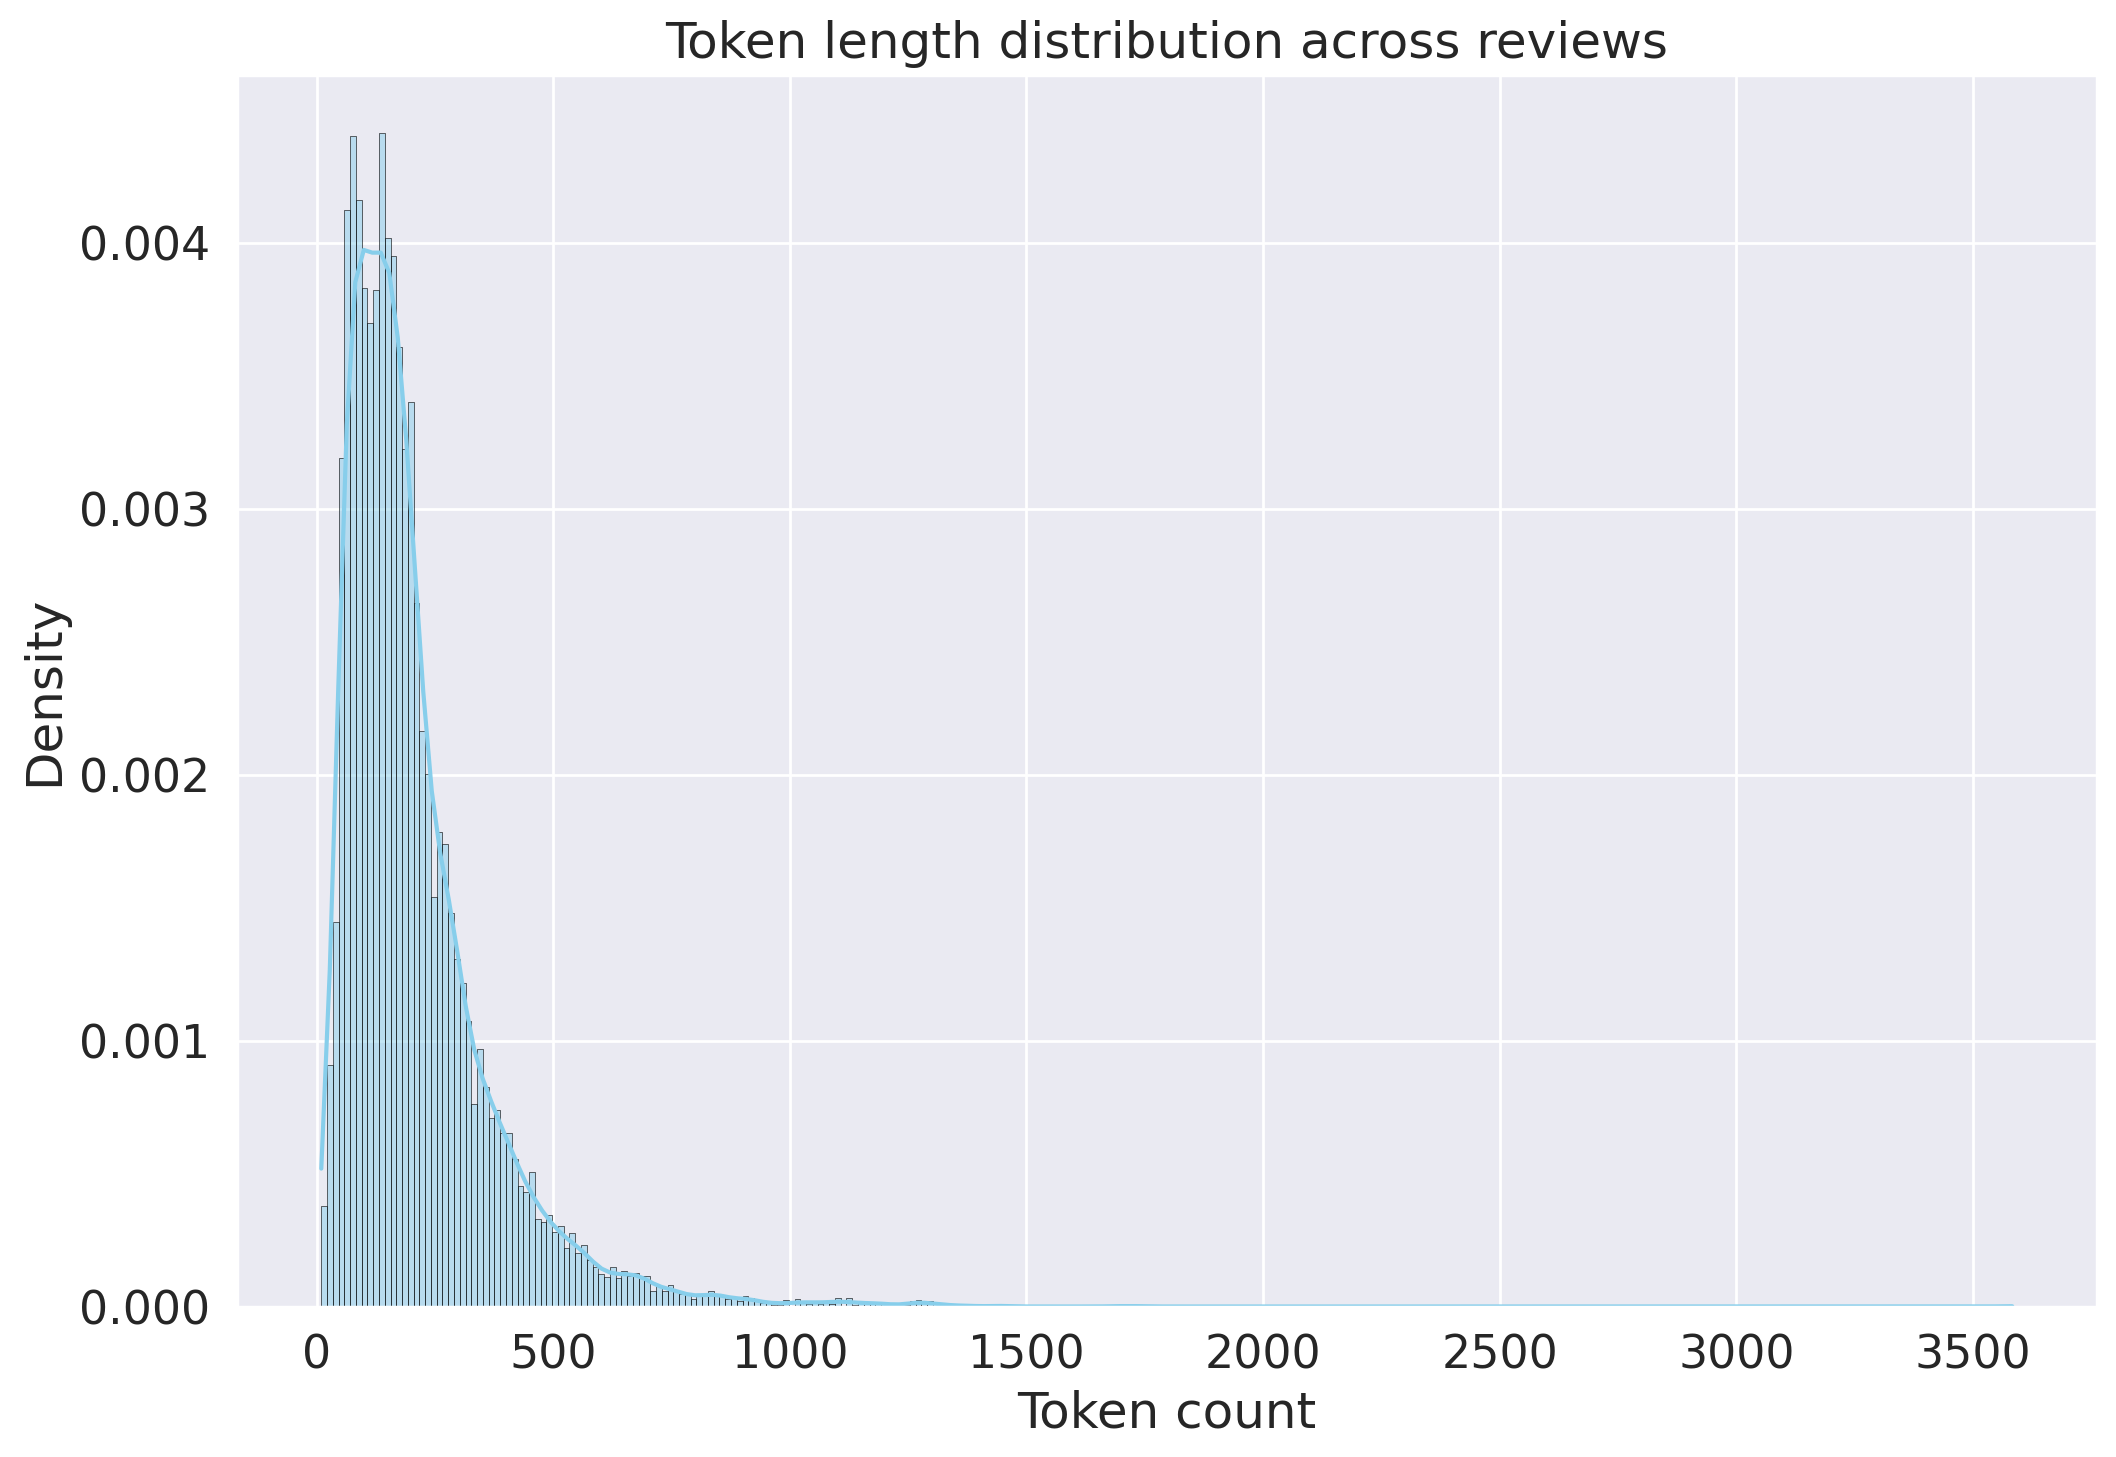

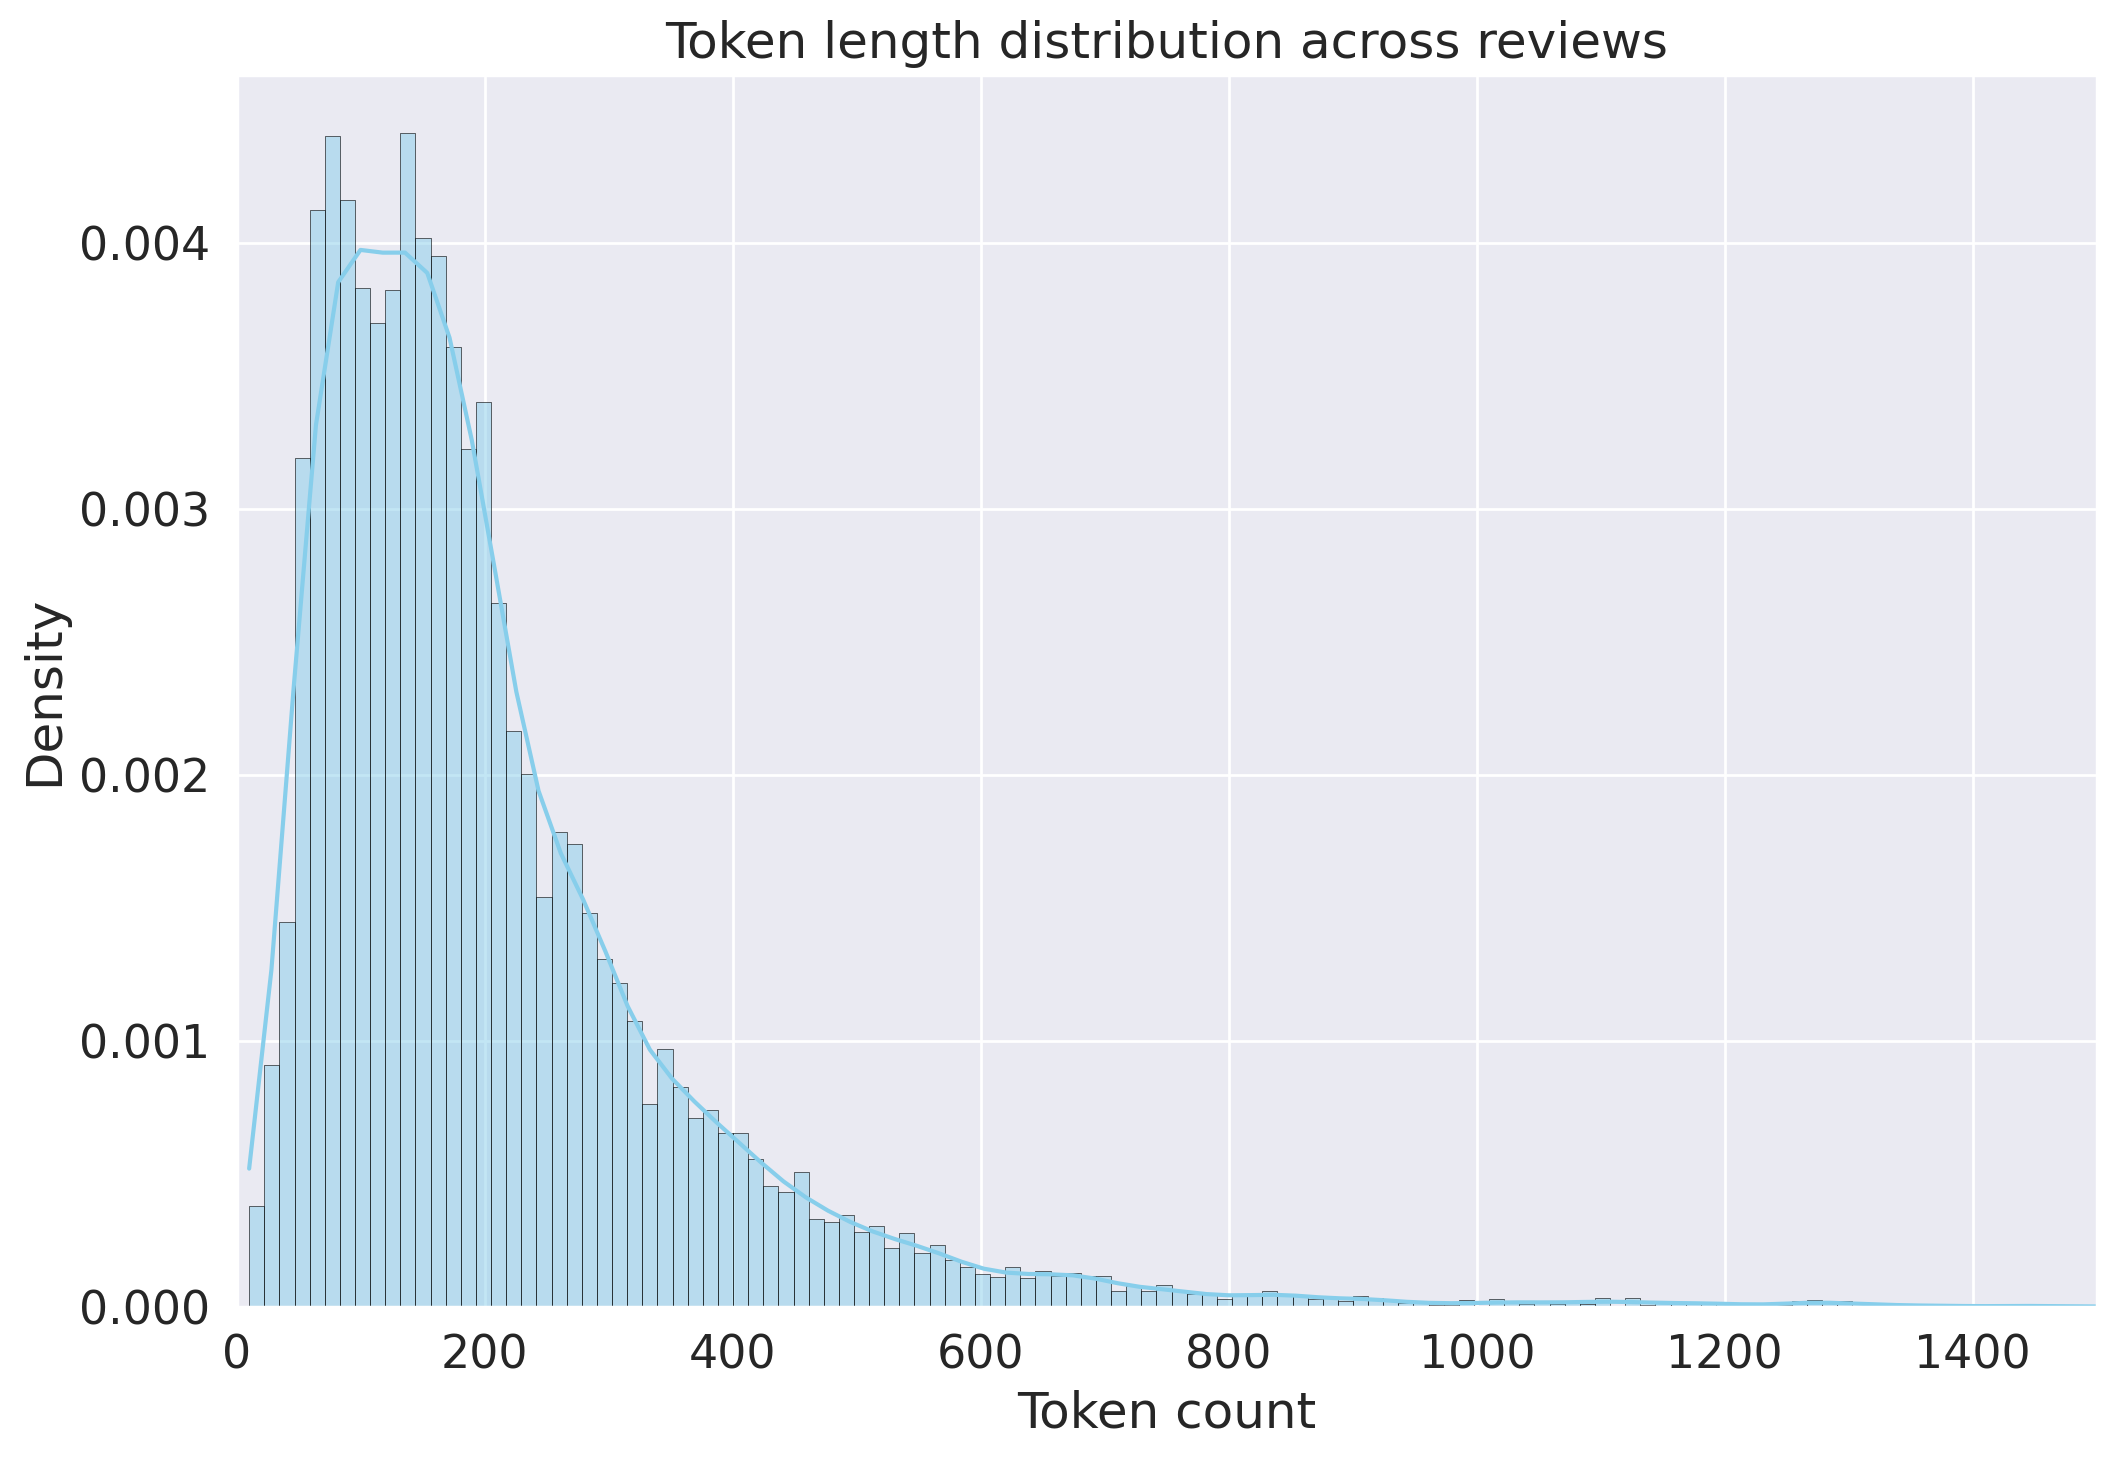

In [19]:
sns.histplot(token_length_list, kde=True, color='skyblue', edgecolor='black',stat='density')
# Histogram of the data with a kernel density estimate (KDE) plot

plt.xlabel('Token count')
plt.ylabel('Density')
plt.title('Token length distribution across reviews')

plt.figure()
sns.histplot(token_length_list, kde=True, color='skyblue', edgecolor='black', stat='density')
plt.xlabel('Token count')
plt.ylabel('Density')
plt.title('Token length distribution across reviews')
plt.xlim(0, 1500)
plt.show()

In [ ]:
check_gpu_info()

GPU memory information:
GPU 0 (Tesla T4): 15102.06 MB total memory
GPU with the highest memory usage:
GPU 0 (Tesla T4): 0.00 MB


## Pre-Processing the Dataset

### Dataset Train, Validation and Test Split

In [ ]:
df_train, df_test = train_test_split(df, test_size = 0.4, random_state = RANDOM_SEED)

df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state = RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(10204, 4) (3402, 4) (3402, 4)


### Tokenizing the Dataset and Creating DataLoaders

In [ ]:
# Defining method for Tokenizing the Dataset
MAX_LEN = 512
BATCH_SIZE = 16

# Dataset is an abtract class provided by torch.utils.data
# To use it , Make class whihc is the subclass the Abstract class Dataset , and implement its '__len__' and '__get__item' function
class ReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len, include_raw_text=False):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.include_raw_text = include_raw_text

    # It should returns the length of Dataset
    def __len__(self):
        return len(self.reviews)

    # It should return a sample from the dataset at given index
    # It returns the encoded tokens with their attention mask , the ouput tensor and also review raw_text
    def __getitem__(self,item):
        review = str(self.reviews[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens = True,
            max_length = self.max_len,
            return_token_type_ids = False,
            return_attention_mask = True,
            truncation = True,
            padding='max_length',
            return_tensors = 'pt',
        )

        output = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

        if self.include_raw_text:
            output['review_text'] = review

        return output

In [ ]:
# Creation of DataLoader
# DataLoader is also provided by torch.utils.data
# DataLoader provides a convenient way to iterate over batches of data from a dataset

pre_trained_model_ckpt = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(pre_trained_model_ckpt)

# The DataCollatorWithPadding class is a utility class provided by the Hugging Face transformers library
# It Pad all sequences in the batch to the length of the longest sequence in the batch.
collator = DataCollatorWithPadding(tokenizer=tokenizer, padding = 'longest' )

def create_data_loader(df, tokenizer, max_len = MAX_LEN, batch_size = BATCH_SIZE, include_raw_text = False ):
    ds = ReviewDataset(
        reviews=df.Review.to_list(),
        targets = df.Rating.to_list(),
        tokenizer=tokenizer,
        max_len=max_len,
        include_raw_text=include_raw_text
    )

    return DataLoader(ds, batch_size=batch_size, collate_fn=collator )

In [ ]:
train_data_Loader = create_data_loader(df_train, tokenizer)
val_data_Loader = create_data_loader(df_val, tokenizer)
test_data_Loader = create_data_loader(df_test, tokenizer)

In [ ]:
#Testing to see if the data loader works appropriately
data = next(iter(train_data_Loader))

print(data.keys()) # dict_keys(['input_ids', 'attention_mask', 'targets'])

print(data['input_ids'].shape) # torch.Size([16, 512])

print(data['attention_mask'].shape) # torch.Size([16, 512])

print(data['targets'].shape) # torch.Size([16])

dict_keys(['input_ids', 'attention_mask', 'targets'])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])


## Extending BERT Base Model with a Classifier Layer

In [ ]:
# RatingEstimator is a sublcass of nn.module
# It indcated its pytorch neural network module
# Neec to Implement the forward pass

class RatingEstimator(nn.Module):

      def __init__(self, n_classes):
            # Caling the constructor of 'nn.Module' to initialize the network
            super(RatingEstimator, self).__init__()

            # Loading the pre-trained Bert-base model , it returns output as seperate tensors rather than as a  dictionary
            self.bert = BertModel.from_pretrained(pre_trained_model_ckpt,return_dict=False)

            # Multiple inear Layer with Relu activation
            # Final linear layer that maps the output of the BERT model to the number of classes
            # This layer will be responsible for the final classification.
            self.classifier = nn.Sequential(
                  nn.Dropout(p = 0.3),
                  nn.Linear(768, 512),
                  nn.ReLU(),
                  nn.Linear(512, 256),
                  nn.ReLU(),
                  nn.Linear(256, n_classes),
            )

      def forward(self, input_ids, attention_mask):

            # Bert model takes the input token ids and attention mask as input
            _, pooled_output = self.bert(
                  input_ids = input_ids,
                  attention_mask= attention_mask
            )

            # Applying dropout and passes through final linear layer
            output = self.classifier(pooled_output)
            return output

In [ ]:
model = RatingEstimator(len(class_names))
model = model.to(device)
model

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

RatingEstimator(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [ ]:
check_gpu_info()

GPU memory information:
GPU 0 (Tesla T4): 15102.06 MB total memory
GPU with the highest memory usage:
GPU 0 (Tesla T4): 421.24 MB


In [ ]:
# Just An evaluation run of the model
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

# input_ids = data['input_ids']
# attention_mask = data['attention_mask']

final_output = F.softmax(model(input_ids,attention_mask), dim = 1)

input_ids = input_ids.detach()
attention_mask = attention_mask.detach()
final_output = final_output.detach()

torch.cuda.empty_cache()

final_output

tensor([[0.1965, 0.1906, 0.1984, 0.2091, 0.2054],
        [0.1888, 0.1815, 0.1937, 0.2245, 0.2115],
        [0.1901, 0.2032, 0.1965, 0.2146, 0.1956],
        [0.1860, 0.1897, 0.1918, 0.2171, 0.2154],
        [0.1904, 0.1889, 0.2054, 0.2217, 0.1936],
        [0.1951, 0.1954, 0.1918, 0.2198, 0.1979],
        [0.1799, 0.2024, 0.1804, 0.2298, 0.2076],
        [0.1937, 0.1908, 0.1905, 0.2103, 0.2147],
        [0.2053, 0.2011, 0.1733, 0.2193, 0.2011],
        [0.1913, 0.1903, 0.1793, 0.2202, 0.2189],
        [0.1972, 0.1905, 0.1921, 0.2241, 0.1961],
        [0.1876, 0.1873, 0.1836, 0.2270, 0.2144],
        [0.2037, 0.1973, 0.1833, 0.2119, 0.2038],
        [0.1904, 0.1962, 0.1972, 0.2232, 0.1930],
        [0.1975, 0.1864, 0.1975, 0.2188, 0.1997],
        [0.2032, 0.1940, 0.1860, 0.2189, 0.1979]], device='cuda:0')

In [ ]:
check_gpu_info()

GPU memory information:
GPU 0 (Tesla T4): 15102.06 MB total memory
GPU with the highest memory usage:
GPU 0 (Tesla T4): 429.49 MB


## Training the Model

In [ ]:
# Defining loss function ,Optimizer and Scheduler

EPOCHS = 10
learning_rate = 1e-5
total_steps = len(train_data_Loader)*EPOCHS

optimizer = optim.Adam(model.parameters(),lr=learning_rate)

# The Scheduler will modify learning rate after each iteration that speed-up the convergence.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# loss_fn = nn.CrossEntropyLoss().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)


In [ ]:
check_gpu_info()

GPU memory information:
GPU 0 (Tesla T4): 15102.06 MB total memory
GPU with the highest memory usage:
GPU 0 (Tesla T4): 429.49 MB


In [ ]:
# The 'train_model' function below trains the model (forward pass and backward pass) for one epoch
# It also calculate accuracy and average loss for an epoch.

def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples, print_every=100):
    model = model.train()
    train_loss = []
    correct_predictions = 0

    print('Training on Train Dataset')

    # loop for a batch
    for batch_idx, d in enumerate(data_loader):
        input_ids = d['input_ids'].to(device)
        attention_masks = d['attention_mask'].to(device)
        targets = d['targets'].to(device)

        # Forward Pass
        output = model(input_ids, attention_masks)
        loss = loss_fn(output, targets) 
        _, preds = torch.max(output, dim=1)

        # Backward Propagation
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Training loss and number of correct prediction
        train_loss.append(loss.item())
        correct_predictions += torch.sum(preds == targets)

        input_ids = input_ids.detach()
        attention_masks = attention_masks.detach()
        targets = targets.detach()

        if batch_idx % print_every == 0:
            print(f'At Batch {batch_idx}/{len(data_loader)}, Loss: {loss.item()}')

    accuracy = correct_predictions / n_examples
    average_loss = np.mean(train_loss)

    return accuracy, average_loss

In [ ]:
# The 'eval_model' fuction evaluate model performance on evaluation data for every epoch
# It is done by calculation accuracy and average loss.

def eval_model(model, data_loader, loss_fn, device, n_examples, print_every=100):
    model = model.eval()
    eval_loss = []
    correct_predictions = 0

    print('Evaluation on Validation Dataset')

    # loop for a batch
    with torch.no_grad():
      for batch_idx, d in enumerate(data_loader):
          input_ids = d['input_ids'].to(device)
          attention_masks = d['attention_mask'].to(device)
          targets = d['targets'].to(device)

          # Forward Pass
          output = model(input_ids, attention_masks)
          _, preds = torch.max(output, dim=1)

          # Evaluation loss and number of correct predictions
          loss = loss_fn(output, targets)
          correct_predictions += torch.sum(preds == targets)
          eval_loss.append(loss.item())

          input_ids = input_ids.detach()
          attention_masks = attention_masks.detach()
          targets = targets.detach()

          if batch_idx % print_every == 0:
              print(f'At Batch {batch_idx}/{len(data_loader)}, Loss: {loss.item()}')

    accuracy = correct_predictions / n_examples
    average_loss = np.mean(eval_loss)

    return accuracy, average_loss


In [ ]:
check_gpu_info()

GPU memory information:
GPU 0 (Tesla T4): 15102.06 MB total memory
GPU with the highest memory usage:
GPU 0 (Tesla T4): 429.49 MB


### Training Loop

In [ ]:
file_path = '/content/drive/MyDrive/IMDB_User_Movie_Rating_Dataset_By_Web_Scrapping/Model_and_state_save/finetune_bert_best_model_parameters.bin'
history = defaultdict(list)
best_accuracy = 0

print(f'In this {file_path}')
print('Model Weights and parameters will be saved')
print(' ')

# In this loop we are calling functions train_model() and eval_model()   and validation data
# Printing the accuracy and loss for both training and validation data for every epoch
# Also saving the model if model performance on validation data improves than the performance in previous epoch.
for epoch in range(EPOCHS):

    # Training
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-'*45)

    train_acc, train_loss = train_model(
        model,
        train_data_Loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f'Training loss: {train_loss}, Training accuracy: {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_Loader,
        loss_fn,
        device,
        len(df_val)
    )
    print(f'Validation loss: {val_loss}, Validation accuracy: {val_acc}')

    # saving the logs
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)


    if val_acc>best_accuracy:
        torch.save(model.state_dict(), file_path)
        best_accuracy = val_acc
        print(f'Model Weights and Parameters has been saved')

    print(' ')



In this /content/drive/MyDrive/IMDB_User_Movie_Rating_Dataset_By_Web_Scrapping/Model_and_state_save/finetune_bert_best_model_parameters.bin
Model Weights and parameters will be saved
 
Epoch 1/10
---------------------------------------------
Training on Train Dataset
At Batch 0/638, Loss: 1.6231824159622192
At Batch 100/638, Loss: 1.577833890914917
At Batch 200/638, Loss: 1.3907091617584229
At Batch 300/638, Loss: 1.1325682401657104
At Batch 400/638, Loss: 1.1438196897506714
At Batch 500/638, Loss: 1.163562297821045
At Batch 600/638, Loss: 1.3489818572998047
Training loss: 1.308504493912933, Training accuracy: 0.43522146344184875
Evaluation on Validation Dataset
At Batch 0/213, Loss: 1.1551144123077393
At Batch 100/213, Loss: 0.8650509119033813
At Batch 200/213, Loss: 1.135319709777832
Validation loss: 1.108105846693818, Validation accuracy: 0.5399764776229858
Model Weights and Parameters has been saved
 
Epoch 2/10
---------------------------------------------
Training on Train Datase

In [ ]:
try:
    print(' ')
    accuracy_percentage = best_accuracy * 100
    print("Finally Model Parameters saved with Accuracy: {:.2f}%".format(accuracy_percentage))
except Exception as e:
    print("An error occurred:", e)

 
Finally Model Parameters saved with Accuracy: 58.02%


In [ ]:
train_loss = torch.tensor(history['train_loss'])
val_loss = torch.tensor(history['val_loss'])
train_acc = torch.tensor(history['train_acc'])
val_acc = torch.tensor(history['val_acc'])


# Plotting losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
check_gpu_info()

GPU memory information:
GPU 0 (Tesla T4): 15102.06 MB total memory
GPU with the highest memory usage:
GPU 0 (Tesla T4): 1277.67 MB


## Model Evaluation on test_data_loader

In [ ]:
# get_predictions() is a helper function that take final model and test data as input
# It returns predicted rating, predicted probability for each rating and actual class(label).

def get_prediction(model, data_loader, print_every=40):
    model = model.eval()

    predictions = []
    prediction_probabilities = []
    real_values = []

    print('get prediction function is Called')

    with torch.no_grad():
        for batch_idx, d in enumerate(data_loader):

            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            _, preds = torch.max(outputs, dim=1)
            probs = F.softmax(outputs, dim =1)

            predictions.extend(preds)
            prediction_probabilities.extend(probs)
            real_values.extend(targets)

            input_ids = input_ids.detach()
            attention_mask = attention_mask.detach()
            targets = targets.detach()

            if (batch_idx + 1) % print_every == 0:
                print(f'Processed {batch_idx + 1} batches.')

    # 'torch.stack' function call stacks tensors along a new dimension (default behavior is dim=0)
    predictions = torch.stack(predictions).cpu()
    prediction_probabilities = torch.stack(prediction_probabilities).cpu()
    real_values = torch.stack(real_values).cpu()

    return predictions, prediction_probabilities, real_values


In [ ]:
y_pred, y_pred_probs, y_test = get_prediction(model, test_data_Loader)

print(classification_report(y_test, y_pred, target_names=class_names))

get prediction function is Called
Processed 40 batches.
Processed 80 batches.
Processed 120 batches.
Processed 160 batches.
Processed 200 batches.
              precision    recall  f1-score   support

      1-Star       0.73      0.72      0.72       653
      2-Star       0.41      0.42      0.41       437
      3-Star       0.57      0.55      0.56       737
      4-Star       0.49      0.48      0.49       741
      5-Star       0.69      0.72      0.70       834

    accuracy                           0.59      3402
   macro avg       0.58      0.58      0.58      3402
weighted avg       0.59      0.59      0.59      3402



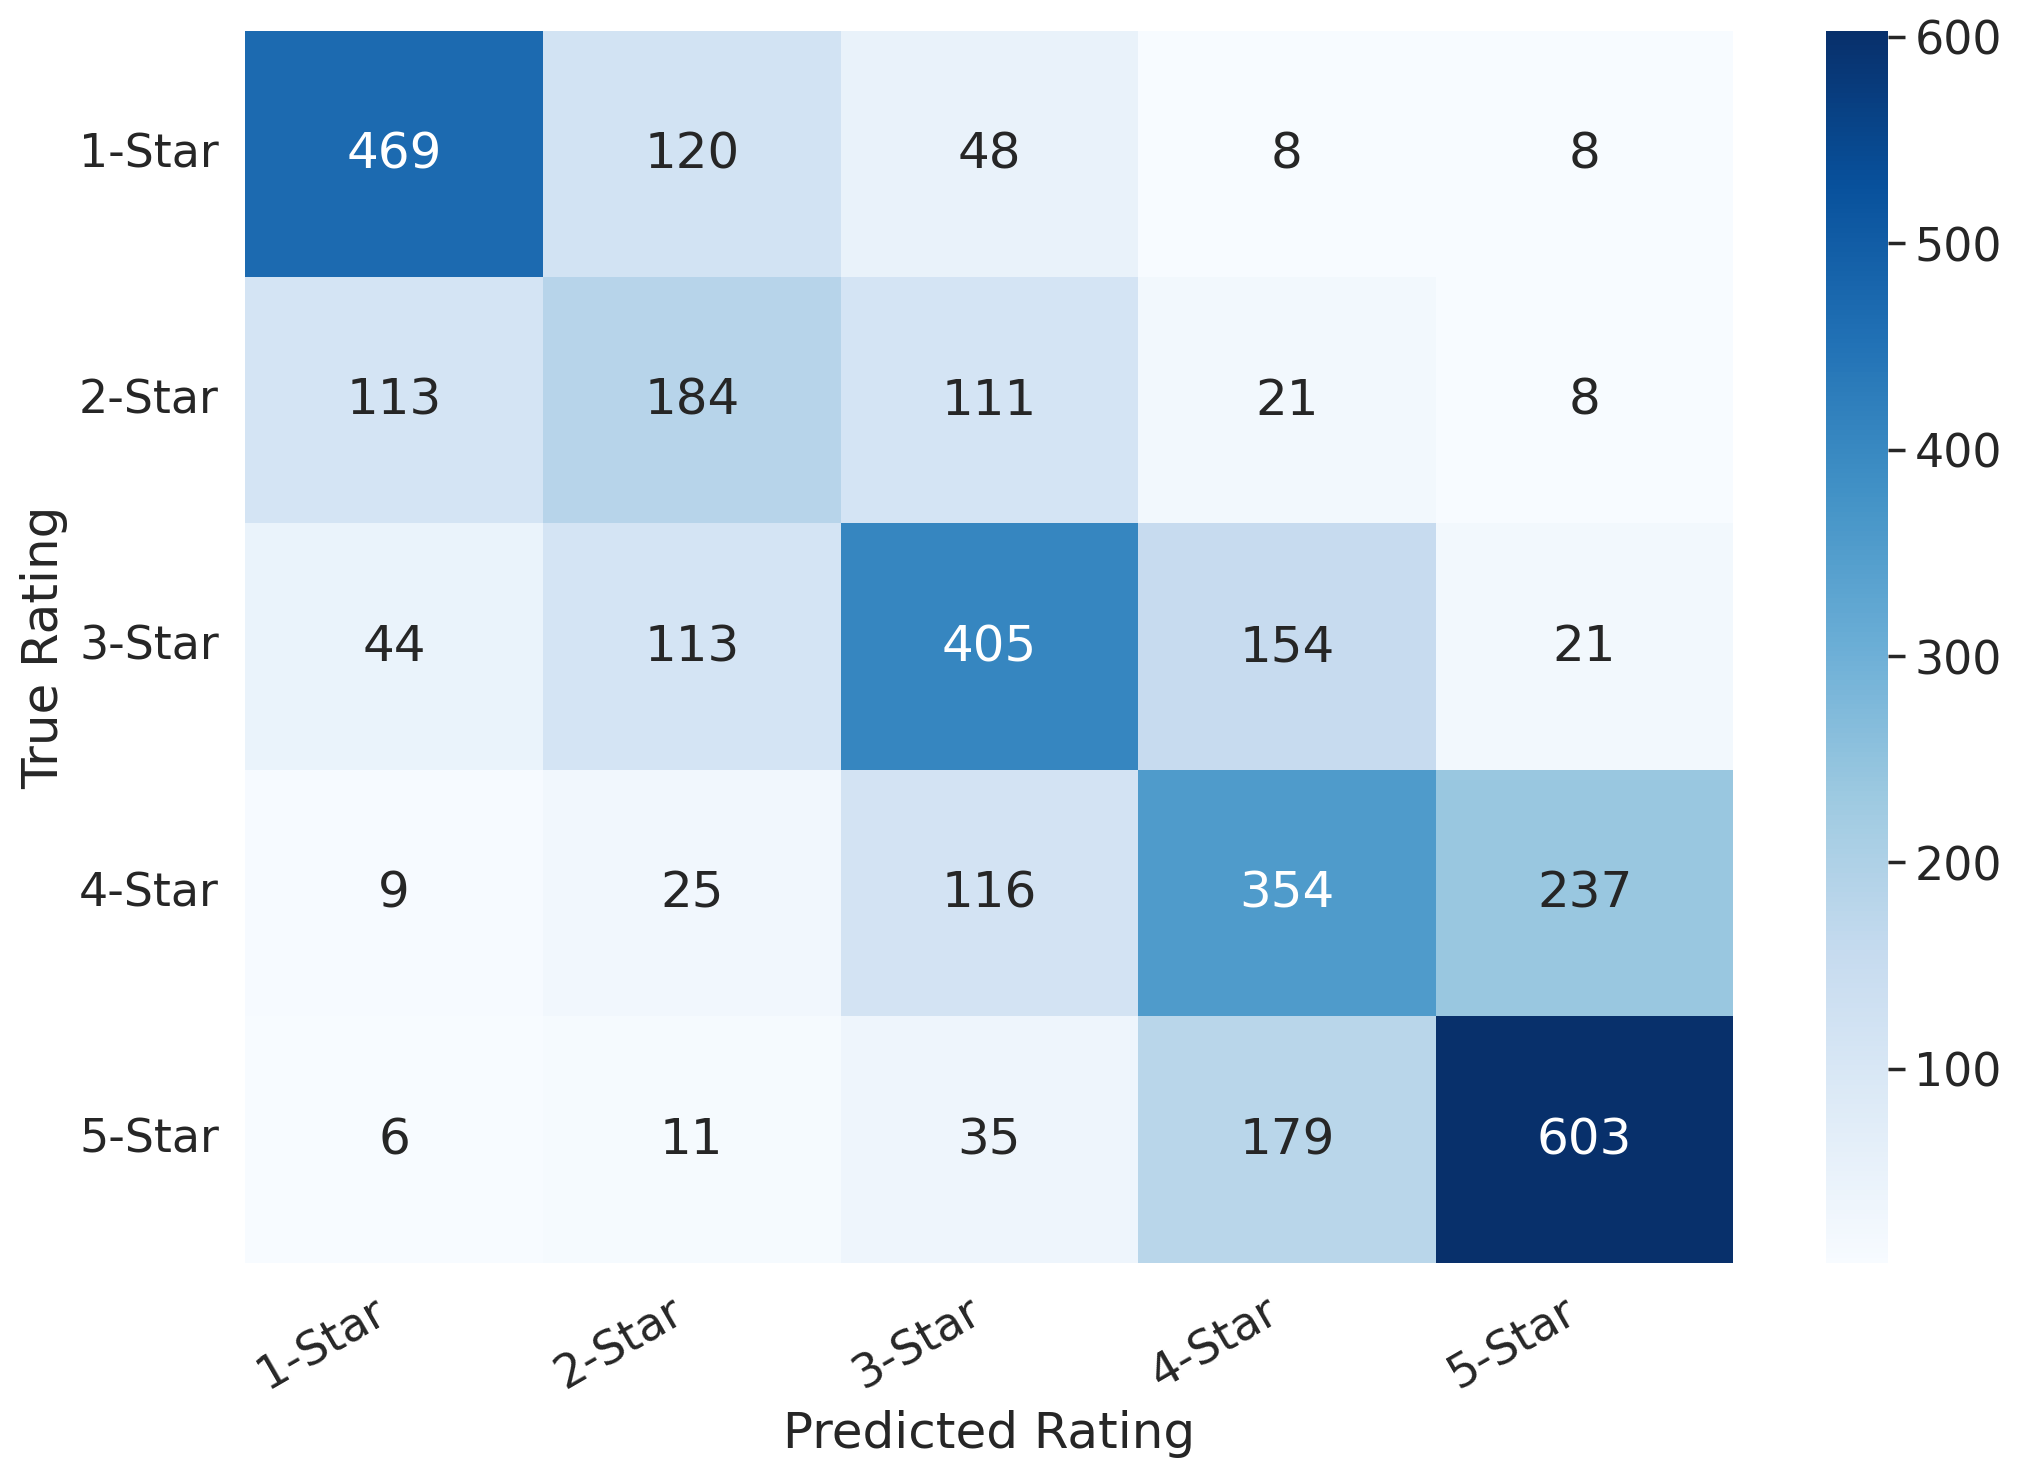

In [ ]:
# Printing the confusion matrix
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation = 30, ha='right')
    plt.ylabel('True Rating')
    plt.xlabel('Predicted Rating')

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns = class_names)
show_confusion_matrix(df_cm)


## Testing the Model on Unseen Data

In [ ]:
# Predicting Rating on Raw text data

def get_rating(sample_review):

    encoded_review = tokenizer.encode_plus(
        sample_review,
        max_length=MAX_LEN,
        truncation=True,
        padding=True,
        add_special_tokens=True,
        return_token_type_ids=False,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids,attention_mask)
    _,prediction = torch.max(output,dim=1)

    print(f'Review text : {sample_review}')
    print(f'Rating : {class_names[prediction]}')

sample_text = 'This movie is a whimsical escape into nostalgia, where Woody Allens romantic portrayal of Paris shines, yet its narrative depth struggles to match the enchanting backdrop.'

get_rating(sample_text)

Review text : This movie is a whimsical escape into nostalgia, where Woody Allens romantic portrayal of Paris shines, yet its narrative depth struggles to match the enchanting backdrop.
Rating : 3-Star
